In [140]:
def string_adapt(val, src='SOURCE', job='node_exporter', interval='1m'): 
    return val.replace('$node', src).replace('$job', job).replace('$__rate_interval', interval)


In [171]:
from prometheus_api_client import PrometheusConnect
import matplotlib.pyplot as plt
import pandas as pd
from time import localtime, mktime

# Connect to Prometheus
prometheus_url = "http://localhost:9090"  # Replace with the URL of your Prometheus server
prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)

# Query processor usage data for the 'node_exporter' job and 'SOURCE' instance

# query = 'sum by(instance) (irate(node_cpu_seconds_total{instance="$node",job="$job", mode="system"}[$__rate_interval])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="$node",job="$job"}[$__rate_interval])))'
# query = string_adapt(query, interval='15s')
# query = '100 - (avg_over_time(node_cpu_seconds_total{job="node_exporter", instance="SOURCE"}[1m]) * 100)'
query = '(irate(node_cpu_seconds_total{job="node_exporter", instance="SOURCE"}[5m]))'
result = prom.custom_query(query=query)
print(len(result))


64


In [8]:
result_df = pd.DataFrame(columns=['processor', 'time', 'cpu', 'instance', 'job', 'mode'])
met_val_list = [pd.concat([pd.Series(ii['value'], index=['time', 'processor']), pd.Series(ii['metric'])]) for ii in result]
for ii in met_val_list:
    result_df = pd.concat([result_df, ii.to_frame().T])
    
result_df.reset_index(drop=True, inplace=True)
result_df.time = pd.to_datetime(result_df.time, origin="unix", unit="s", utc=True).apply(lambda x: x.tz_convert('America/Fortaleza'))
result_df.processor = result_df.processor.astype(float)
result_df.cpu = result_df.cpu.astype(float)
display(result_df.head())
result_df.info()

,processor,time,cpu,instance,job,mode
0,0.998,2023-10-27 08:34:08.323999882-03:00,0.0,SOURCE,node_exporter,idle
1,0.000,2023-10-27 08:34:08.323999882-03:00,0.0,SOURCE,node_exporter,iowait
2,0.000,2023-10-27 08:34:08.323999882-03:00,0.0,SOURCE,node_exporter,irq
3,0.000,2023-10-27 08:34:08.323999882-03:00,0.0,SOURCE,node_exporter,nice
4,0.000,2023-10-27 08:34:08.323999882-03:00,0.0,SOURCE,node_exporter,softirq


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype                            
---  ------     --------------  -----                            
 0   processor  64 non-null     float64                          
 1   time       64 non-null     datetime64[ns, America/Fortaleza]
 2   cpu        64 non-null     float64                          
 3   instance   64 non-null     object                           
 4   job        64 non-null     object                           
 5   mode       64 non-null     object                           
dtypes: datetime64[ns, America/Fortaleza](1), float64(2), object(3)
memory usage: 3.1+ KB


In [233]:
# Split result_df.time into date and time
result_df['date'] = result_df.time.dt.date
# Time only show hour, minute and second
result_df['time'] = result_df.time.dt.time
# result_df['time'] = pd.to_datetime(result_df['time'], format='%H:%M:%S').dt.time
result_df.head()

,processor,time,cpu,instance,job,mode,date
0,0.993801,23:50:27.183000,4.0,SOURCE,node_exporter,idle,2023-10-26
1,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,iowait,2023-10-26
2,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,irq,2023-10-26
3,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,nice,2023-10-26
4,0.000000,23:50:27.183000,4.0,SOURCE,node_exporter,softirq,2023-10-26


<Axes: ylabel='processor'>

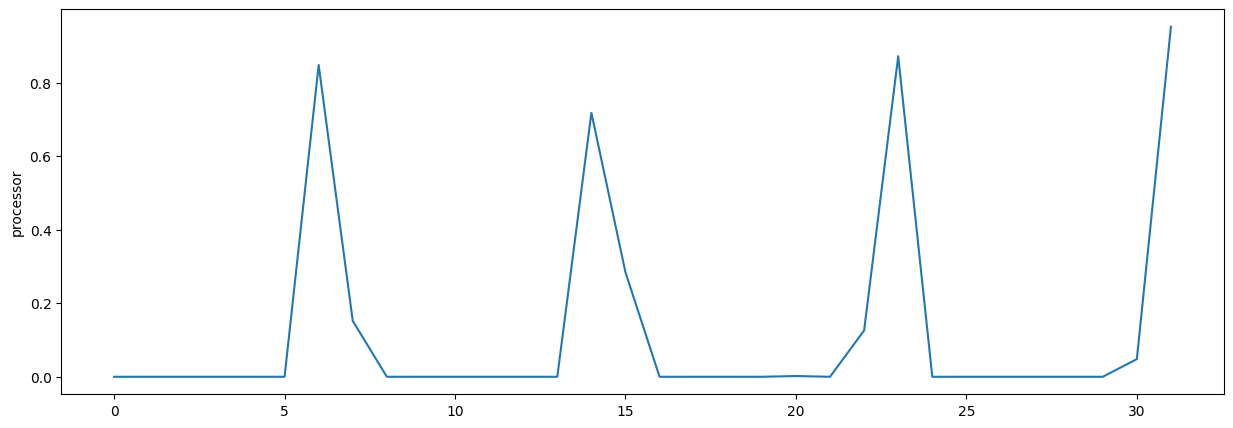

In [265]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(len(result_df.processor)), y='processor', data=result_df, ax=ax)

In [205]:
from prometheus_api_client import MetricsList
import datetime

prometheus_url = "http://localhost:9090"  # Replace with the URL of your Prometheus server
prom = PrometheusConnect(url=prometheus_url, disable_ssl=True)


result_list = prom.get_metric_range_data(metric_name='node_cpu_seconds_total',
                                         label_config={"job":"node_exporter", "instance":"SOURCE"},
                                         start_time=datetime.datetime(2023, 10, 27, 9, 52, 45, 34582),
                                         end_time=datetime.datetime(2023, 10, 27, 10, 9, 45, 34582))

In [206]:
result_df = pd.DataFrame(columns=['time', 'processor', '__name__', 'cpu', 'instance', 'job', 'mode'])

for ii in result_list:
    t1 = pd.DataFrame(ii['values'], columns=['time', 'cpu'])
    t1.rename(columns={'cpu':'processor'}, inplace=True)
    t2 = pd.concat([pd.DataFrame(ii['metric'], index=[0])] * len(t1), ignore_index=True)
    t3 = pd.concat([t1, t2], axis=1)
    result_df = pd.concat([result_df, t3])
    
result_df.reset_index(drop=True, inplace=True)
result_df.time = pd.to_datetime(result_df.time, origin="unix", unit="s", utc=True).apply(lambda x: x.tz_convert('America/Fortaleza'))
result_df.processor = result_df.processor.astype(float)
result_df.cpu = result_df.cpu.astype(int)
display(result_df.head())
result_df.info()

,time,processor,__name__,cpu,instance,job,mode
0,2023-10-27 09:52:47.298000128-03:00,70646.23,node_cpu_seconds_total,0,SOURCE,node_exporter,idle
1,2023-10-27 09:52:52.298000128-03:00,70651.23,node_cpu_seconds_total,0,SOURCE,node_exporter,idle
2,2023-10-27 09:52:57.298000128-03:00,70656.20,node_cpu_seconds_total,0,SOURCE,node_exporter,idle
3,2023-10-27 09:53:02.298000128-03:00,70661.14,node_cpu_seconds_total,0,SOURCE,node_exporter,idle
4,2023-10-27 09:53:07.298000128-03:00,70666.13,node_cpu_seconds_total,0,SOURCE,node_exporter,idle


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13056 entries, 0 to 13055
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype                            
---  ------     --------------  -----                            
 0   time       13056 non-null  datetime64[ns, America/Fortaleza]
 1   processor  13056 non-null  float64                          
 2   __name__   13056 non-null  object                           
 3   cpu        13056 non-null  int64                            
 4   instance   13056 non-null  object                           
 5   job        13056 non-null  object                           
 6   mode       13056 non-null  object                           
dtypes: datetime64[ns, America/Fortaleza](1), float64(1), int64(1), object(4)
memory usage: 714.1+ KB


In [207]:
mask = result_df['mode'] == 'idle'
idle = result_df.loc[mask, ['time', 'cpu', 'processor']]
print(idle.shape)
display(idle.head())
combine = result_df.loc[~mask, ['time', 'cpu', 'processor']].groupby(['time', 'cpu']).processor.sum().to_frame().reset_index()
# combine['mode'] = 'combine'
# combine = pd.concat([combine, idle], axis=0).reset_index(drop=True)
combine.processor = idle.processor - combine.processor
combine.head()

(1632, 3)


,time,cpu,processor
0,2023-10-27 09:52:47.298000128-03:00,0,70646.23
1,2023-10-27 09:52:52.298000128-03:00,0,70651.23
2,2023-10-27 09:52:57.298000128-03:00,0,70656.20
3,2023-10-27 09:53:02.298000128-03:00,0,70661.14
4,2023-10-27 09:53:07.298000128-03:00,0,70666.13


,time,cpu,processor
0,2023-10-27 09:52:47.298000128-03:00,0,70432.22
1,2023-10-27 09:52:47.298000128-03:00,1,70445.84
2,2023-10-27 09:52:47.298000128-03:00,2,70459.32
3,2023-10-27 09:52:47.298000128-03:00,3,70473.93
4,2023-10-27 09:52:47.298000128-03:00,4,70528.07


<AxesSubplot:xlabel='time', ylabel='processor'>

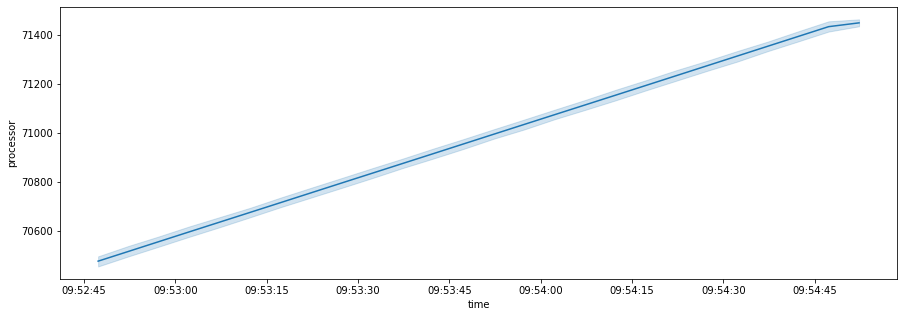

In [208]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x='time', y='processor', data=combine, ax=ax)

In [226]:
query1 = 'sum by(instance) (irate(node_cpu_seconds_total{instance="$node",job="$job", mode!="idle"}[$__rate_interval])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="$node",job="$job"}[$__rate_interval])))'
query1 = string_adapt(query1, interval='30m')

query2 = 'sum by(instance) (irate(node_cpu_seconds_total{instance="$node",job="$job", mode="idle"}[$__rate_interval])) / on(instance) group_left sum by (instance)((irate(node_cpu_seconds_total{instance="$node",job="$job"}[$__rate_interval])))'
query2 = string_adapt(query2, interval='30m')


In [247]:
# query = 'sum by(instance) (irate(node_cpu_seconds_total{instance="SOURCE",job="node_exporter", mode="system"}[30m]))'
# query = '100 - (avg_over_time(node_cpu_seconds_total{job="node_exporter", instance="SOURCE"}[1m]) * 100)'
result1 = prom.custom_query_range(query=query1, step='5s', start_time=datetime.datetime(2023, 10, 27, 9, 52, 45, 34582),
                                         end_time=datetime.datetime(2023, 10, 27, 10, 9, 45, 34582))

result2 = prom.custom_query_range(query=query2, step='5s', start_time=datetime.datetime(2023, 10, 27, 9, 52, 45, 34582),
                                         end_time=datetime.datetime(2023, 10, 27, 10, 9, 45, 34582))

len(result2[0]['values'])

205

In [248]:
result_df1 = pd.DataFrame(columns=['time', 'processor', 'cpu', 'instance', 'job', 'mode'])
result_df2 = pd.DataFrame(columns=['time', 'processor', 'cpu', 'instance', 'job', 'mode'])

for ii in result1:
    t1 = pd.DataFrame(ii['values'], columns=['time', 'cpu'])
    t1.rename(columns={'cpu':'processor'}, inplace=True)
    t2 = pd.concat([pd.DataFrame(ii['metric'], index=[0])] * len(t1), ignore_index=True)
    t3 = pd.concat([t1, t2], axis=1)
    result_df1 = pd.concat([result_df1, t3])

for ii in result2:
    t1 = pd.DataFrame(ii['values'], columns=['time', 'cpu'])
    t1.rename(columns={'cpu':'processor'}, inplace=True)
    t2 = pd.concat([pd.DataFrame(ii['metric'], index=[0])] * len(t1), ignore_index=True)
    t3 = pd.concat([t1, t2], axis=1)
    result_df2 = pd.concat([result_df2, t3])
    
result_df1.reset_index(drop=True, inplace=True)
result_df1.time = pd.to_datetime(result_df1.time, origin="unix", unit="s", utc=True).apply(lambda x: x.tz_convert('America/Fortaleza'))
result_df1.processor = result_df1.processor.astype(float)
# result_df.cpu = result_df.cpu.astype(int)
display(result_df1.head())
# result_df.info()

result_df2.reset_index(drop=True, inplace=True)
result_df2.time = pd.to_datetime(result_df2.time, origin="unix", unit="s", utc=True).apply(lambda x: x.tz_convert('America/Fortaleza'))
result_df2.processor = result_df2.processor.astype(float)
# result_df.cpu = result_df.cpu.astype(int)
display(result_df2.head())

,time,processor,cpu,instance,job,mode
0,2023-10-27 09:52:45-03:00,0.002506,NaN,SOURCE,NaN,NaN
1,2023-10-27 09:52:50-03:00,0.002500,NaN,SOURCE,NaN,NaN
2,2023-10-27 09:52:55-03:00,0.003247,NaN,SOURCE,NaN,NaN
3,2023-10-27 09:53:00-03:00,0.003004,NaN,SOURCE,NaN,NaN
4,2023-10-27 09:53:05-03:00,0.002009,NaN,SOURCE,NaN,NaN


,time,processor,cpu,instance,job,mode
0,2023-10-27 09:52:45-03:00,0.997494,NaN,SOURCE,NaN,NaN
1,2023-10-27 09:52:50-03:00,0.997500,NaN,SOURCE,NaN,NaN
2,2023-10-27 09:52:55-03:00,0.996753,NaN,SOURCE,NaN,NaN
3,2023-10-27 09:53:00-03:00,0.996996,NaN,SOURCE,NaN,NaN
4,2023-10-27 09:53:05-03:00,0.997991,NaN,SOURCE,NaN,NaN


In [249]:
result_df1.shape, result_df2.shape

((205, 6), (205, 6))

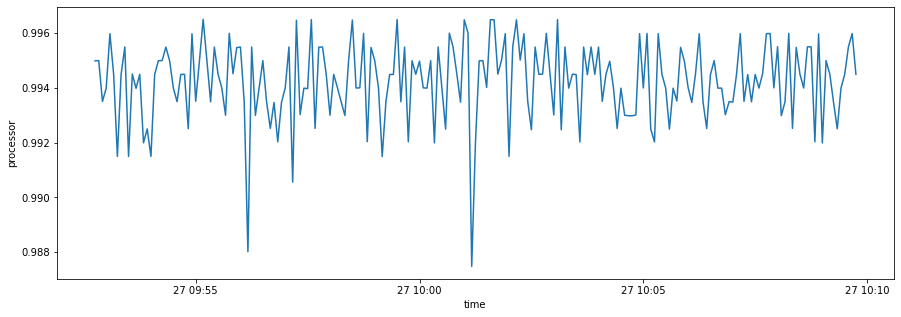

In [255]:
fig, ax = plt.subplots(figsize=(15, 5))
# mask = (result_df['mode'] == 'user') | (result_df['mode'] == 'system')
grouped_df1 = result_df1.groupby(['time']).processor.sum().to_frame().reset_index()
grouped_df2 = result_df2.groupby(['time']).processor.sum().to_frame().reset_index()

grouped_df = pd.DataFrame(columns=['time', 'processor'])
grouped_df['processor'] = grouped_df2.processor - grouped_df1.processor
grouped_df['time'] = grouped_df1.time

sns.lineplot(x='time', y='processor', data=grouped_df, ax=ax)
plt.show()